In [2]:
import torch
from torch import nn
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader

import os
import shutil
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

PATH = 'data/datasets/unzipped_dataset/dataset5/'
SIGNERS = ['A', 'B', 'C', 'D', 'E']

In [3]:
class HandGestureDataset(Dataset):
    SPLIT_RANDOM_SEED = 42
    TEST_SIZE = 0.25

    def __init__(self, root, signers_list, train=True, load_to_ram=True, transform=None):
        super().__init__()
        self.root = root
        self.signers_list = signers_list
        self.train = train
        self.load_to_ram = load_to_ram
        self.transform = transform
        self.to_tensor = T.ToTensor()
        self.all_files = []
        self.all_labels = []
        self.images = []

        self.classes = sorted(os.listdir(self.root + self.signers_list[0]))
        for signer in self.signers_list:
            for i, class_name in tqdm(enumerate(self.classes), total=len(self.classes)):
                class_path = os.path.join(self.root, signer, class_name)
                files = sorted(os.listdir(class_path))
                files = [f for f in files if os.path.isfile(os.path.join(class_path, f))]
                train_files, test_files = train_test_split(files, random_state=self.SPLIT_RANDOM_SEED + i,
                                                           test_size=self.TEST_SIZE, shuffle=True)
                if self.train:
                    if self.load_to_ram:
                        self.images += self._load_images(signer, train_files, i)
                    self.all_files += train_files
                    self.all_labels += [i] * len(train_files)

                else:
                    if self.load_to_ram:
                        self.images += self._load_images(signer, test_files, i)
                    self.all_files += test_files
                    self.all_labels += [i] * len(test_files)

    def _load_images(self, signer, image_files, label):
        images = []
        for filename in image_files:
            image_path = os.path.join(self.root + signer, self.classes[label], filename)
            if os.path.isfile(image_path):
                image = Image.open(image_path).convert('RGB')
                images.append(image)
        return images

    def __len__(self):
        return len(self.all_files)
    
    def get_all_files(self):
        return self.all_files, self.images

    def __getitem__(self, item):
        label = self.all_labels[item]
        if self.load_to_ram:
            image = self.images[item]
        else:
            filename = self.all_files[item]
            signer = self.find_file(self.classes[label], filename)
            image = Image.open(os.path.join(self.root + signer, self.classes[label], filename)).convert('RGB')
            # print(signer, filename, self.classes[label])

        if self.transform is not None:
            image = self.transform(image)

        return image, label
    
    def find_file(self, target_folder, target_file):
        """
        Ищет файл с именем target_file в поддиректориях target_folder внутри root.
        Возвращает путь к файлу и название папки, если он найден, иначе None и пустую строку.
        """
        for root_dir in self.signers_list:
            root_path = os.path.join(self.root, root_dir)
            for dirpath, dirnames, filenames in os.walk(root_path):
                if os.path.basename(dirpath) == target_folder and target_file in filenames:
                    return root_dir
        return None, ""

In [4]:
train_dataset = HandGestureDataset(root=PATH, signers_list=SIGNERS, train=True, load_to_ram=False)

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

In [4]:
image, label = train_dataset[10_001]

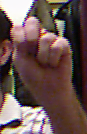

In [5]:
image

### Add augmentation

In [5]:
normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

train_transform = T.Compose([
    T.RandomResizedCrop(224, scale=(0.5, 1.0)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    normalize,
])

test_transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(200),
    T.ToTensor(),
    normalize,
])

In [6]:
train_dataset = HandGestureDataset(root=PATH, signers_list=SIGNERS, train=True, load_to_ram=True, transform=test_transform)
test_dataset = HandGestureDataset(root=PATH, signers_list=SIGNERS, train=False, load_to_ram=True, transform=test_transform)

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

In [7]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True, num_workers=4)

## Model

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm


sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

In [9]:
def training_epoch(model, optimizer, criterion, train_loader, tqdm_desc):
    train_loss, train_accuracy = 0.0, 0.0
    model.train()
    for images, labels in tqdm(train_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.to(device)  # labels: batch_size

        optimizer.zero_grad()
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.shape[0]
        train_accuracy += (logits.argmax(dim=1) == labels).sum().item()
    
    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    return train_loss, train_accuracy


@torch.no_grad()
def validation_epoch(model, criterion, test_loader, tqdm_desc):
    test_loss, test_accuracy = 0.0, 0.0
    model.eval()
    for images, labels in tqdm(test_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.to(device)  # labels: batch_size
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)

        test_loss += loss.item() * images.shape[0]
        test_accuracy += (logits.argmax(dim=1) == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    return test_loss, test_accuracy

    
def train(model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs):
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        test_loss, test_accuracy = validation_epoch(
            model, criterion, test_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )

        if scheduler is not None:
            scheduler.step()

        train_losses += [train_loss]
        train_accuracies += [train_accuracy]
        test_losses += [test_loss]
        test_accuracies += [test_accuracy]
        plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)

    return train_losses, test_losses, train_accuracies, test_accuracies

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## Check different models

In [30]:
class ASL_First_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            # 3*200*200 --> 64*100*100
            nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # 64*100*100 --> 64*50*50
            nn.MaxPool2d(kernel_size=2),
            
            # 64*50*50 --> 64*25*25
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            # 64*25*25 --> 128*13*13
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # 128*13*13 --> 128*3*3
            nn.AdaptiveAvgPool2d((3,3))
        )
            
        self.fc = nn.Sequential(
            nn.Flatten(),
            
            nn.Dropout(0.4),
            nn.Linear(128*3*3, 1024),
            nn.ReLU(inplace=True),
            
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            
            nn.Dropout(0.2),
            nn.Linear(512, 24),
#             nn.Softmax()
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

# model = ASL_First_CNN().to(device)

In [31]:
from torchvision import models
NUM_EPOCHS = 20

model = ASL_First_CNN().to(device)
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
criterion = nn.CrossEntropyLoss()

In [47]:
# from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

# NUM_EPOCHS = 10
# model = mobilenet_v2(num_classes=len(train_dataset.classes)).to(device)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# criterion = torch.nn.CrossEntropyLoss()
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

In [46]:
# sum(param.numel() for param in model.parameters())

2254616

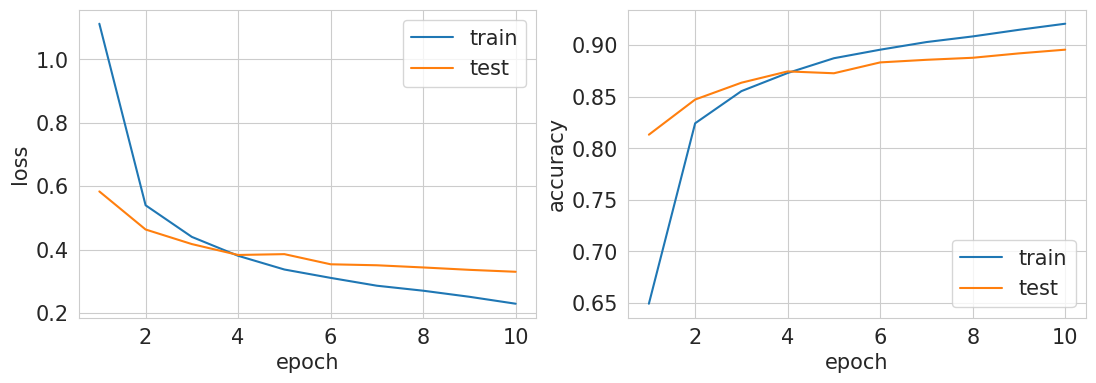

In [48]:
train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, None, criterion, train_loader, test_loader, NUM_EPOCHS
)

In [49]:
torch.save(model.state_dict(), 'asl_first_cnn.pth')

In [34]:
model.load_state_dict(torch.load('asl_first_cnn.pth'))
model.eval()

ASL_First_CNN(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): AdaptiveAvgPool2d(output_size=(3, 3))
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Dropout(p=0.4, inplace=False)
    (2): Linear(in_features=1152, out_features=1024, bias=True)
    (3): ReLU(inplace=True)
    (4): Dropout(p=0.3, inplace=False)
    (5): Linear(in